In [11]:
import analysis.lib.sim.electron_nuclear_sim as en_sim
reload(en_sim)
from scipy.stats import norm
%matplotlib inline

In [64]:
time_duration = 50
pulse_center = 5
dt = 0.1
FWHMs = np.linspace(0.1,3.5,5)
FWHMs = np.array([0.5,1.6,2.3])
mus = FWHMs/2.35482004503

repetitions = 6000

initial_excited_state_pop = 1.0
NV_lifetime = 12.0
decay_prob_per_step = dt/NV_lifetime

In [65]:
init_state = en_sim.ket0.full()
zero_state = en_sim.ket0.full()
total_points = np.ceil(time_duration/np.float(dt) + 1).astype(int)
points = np.arange(total_points).astype(int)
t_array = dt * points
excited_pops = np.zeros([np.shape(mus)[0],total_points])
emitted_photons = np.zeros([np.shape(mus)[0],total_points])
double_pulse_probs = np.zeros(np.shape(mus)[0])
p_photon_during_pulse = np.zeros(np.shape(mus)[0])
p_photon_after_pulse = np.zeros(np.shape(mus)[0])

for kk,mu in enumerate(mus):
    pulse_cut = pulse_center + 3*mu
    pulse_cut_ind = np.argmin(np.abs(t_array - pulse_cut))

    pulse_EField_shape = np.sqrt(norm.pdf(t_array, pulse_center, mu))
    # Need to correct power to ensure full rabi
    EFieldFactor = 2*np.arcsin(np.sqrt(initial_excited_state_pop))/(2**(0.75) * (np.pi)**(0.25) * np.sqrt(mu))
    instaneous_rabi_freq = pulse_EField_shape*EFieldFactor
    unitary = np.zeros([total_points,2,2],dtype=complex)
    for ii in points:
        unitary[ii] = en_sim.spin_y_rotation(instaneous_rabi_freq[ii] * dt).full()

    excited_pop = np.zeros([repetitions,total_points])
    emitted_photon = np.zeros([repetitions,total_points])
    for jj in range(repetitions):
        decay_chance_for_step = np.random.rand(total_points)
        bright_state_chance_for_step = np.random.rand(total_points)
        state = init_state
        for ii in points:
            state =  np.dot(unitary[ii], state)
            excited_pop[jj,ii] = np.abs(state[1])**2
            if decay_chance_for_step[ii] < decay_prob_per_step:
                state = zero_state
                if bright_state_chance_for_step[ii] < excited_pop[jj,ii]:
                    emitted_photon[jj,ii] = 1

    excited_pops[kk] = np.mean(excited_pop,axis=0)
    emitted_photons[kk] = np.mean(emitted_photon,axis=0)
    photon_during_pulse = np.sum(emitted_photon[:,0:pulse_cut_ind],axis=1).astype(int)
    photon_after_pulse = np.sum(emitted_photon[:,pulse_cut_ind:],axis=1).astype(int)
    
    p_photon_during_pulse[kk] = np.mean(photon_during_pulse)
    p_photon_after_pulse[kk] = np.mean(photon_after_pulse)
    double_pulse_probs[kk] = np.mean(np.logical_and(photon_during_pulse,photon_after_pulse))

cond_prob_double_pulse = double_pulse_probs/p_photon_after_pulse


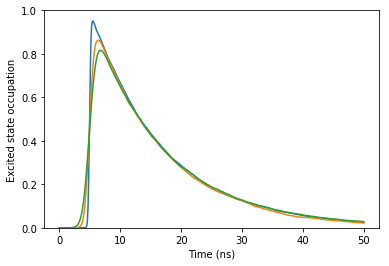

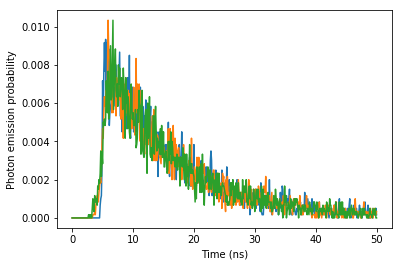

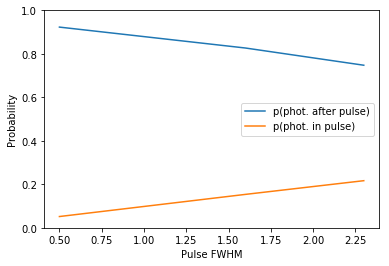

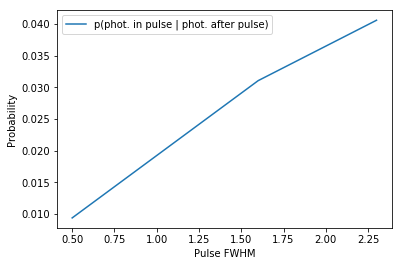

In [67]:
plt.figure()
plt.plot(t_array,np.transpose(excited_pops))
plt.ylim([0,1]);
plt.xlabel('Time (ns)')
plt.ylabel('Excited state occupation')

plt.figure()
plt.plot(t_array,np.transpose(emitted_photons))
plt.xlabel('Time (ns)')
plt.ylabel('Photon emission probability')

plt.figure()
plt.plot(FWHMs,p_photon_after_pulse,label = 'p(phot. after pulse)')
plt.plot(FWHMs,p_photon_during_pulse,label = 'p(phot. in pulse)')
plt.xlabel('Pulse FWHM')
plt.ylabel('Probability')
plt.ylim([0,1]);
plt.legend()

plt.figure()
plt.plot(FWHMs,cond_prob_double_pulse,label = 'p(phot. in pulse | phot. after pulse)')
plt.xlabel('Pulse FWHM')
plt.ylabel('Probability')
plt.legend();

In [62]:
print cond_prob_double_pulse

[ 0.00861141  0.03026634  0.03612903]


In [63]:
p_photon_after_pulse

array([ 0.929,  0.826,  0.775])